In [1]:
import proplot as pplt
import pyart                             
import matplotlib.pyplot as plt          
import cartopy.crs as ccrs               
import numpy as np                       
import glob                              
import pandas as pd
import xarray as xr
import salem                             
from datetime import datetime, timedelta 
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [4]:
#### IMPORTANTE:
### Configurando caminhos:
path = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/'
path_radar = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/Dados_radares_FCTH/ref_sintetica/'
path_raios = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/12_01_24_completo.pickle'
path_shapefiles = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/'
output = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/'

### 1) Lendo e gerando indicadores CAPPI com os dados de radar:

In [5]:
############################################################
### Verificando a quantidade de arquivos de radar na pasta:
files = glob.glob(path_radar+'P*.HDF5')
print(len(files))

######################### Função para gerar dicionario com as informações de cada arquivo de radar:
def gera_radares_pyart(file):
    radar = pyart.aux_io.read_gamic(f'{file}')

    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]
    latmin, latmax = radar.gate_latitude['data'].min(), radar.gate_latitude['data'].max()
    lonmin, lonmax = radar.gate_longitude['data'].min(), radar.gate_longitude['data'].max()
    data = pyart.util.datetime_from_grid(radar)
    ano = str(data.year)
    mes = str(data.month).zfill(2)
    dia = str(data.day).zfill(2)
    hor = str(data.hour).zfill(2)
    min = str(data.minute).zfill(2)

    dic = {'radar':radar, 'lat_radar':lat_radar, 'lon_radar':lon_radar,
           'data':[ano, mes, dia, hor, min], 'altitude':altitude, 
           'extent':[lonmin, lonmax, latmin, latmax]}

    return dic 

#========================================================================================================================#
#  LEITURA DADOS DO RADAR - Chama a função acima e gera uma lista de dicionários, 1 dicionario para cada arquivo de radar
#========================================================================================================================#
dics_radares = [gera_radares_pyart(file) for file in files]
print(len(dics_radares))

1
1


In [6]:
######################### Função para gerar indicador CAPPI. Aqui devem ser configurados a quantidade de pontos
######################### nas direções z, x e y, além dos limites da grade do radar:
def gera_cappis(radar, altitude, lat_radar, lon_radar):
    cappi = pyart.map.grid_from_radars(radar, grid_shape=(8, 500, 500),
                                       grid_limits=((6928. - altitude, 8928.- altitude),
                                                   (-240000., 240000.),
                                                   (-240000., 240000.)),
                                       grid_origin=(lat_radar, lon_radar),
                                       gridding_algo='map_gates_to_grid',
                                       roi_func='dist_beam',
                                       weighting_function='Nearest',
                                       fields=['corrected_reflectivity'])
    
    ### Transformando CAPPI do Py-ART para Dataset do Xarray:
    ds = cappi.to_xarray()
    return ds

#========================================================================================================================#
#      GERANDO O CAPPI - Chama a função acima e gera uma lista de Datasets Xarray, 1 array para cada arquivo de radar
#========================================================================================================================#
lista_cappis = [gera_cappis(d['radar'], d['altitude'], d['lat_radar'], d['lon_radar']) for d in dics_radares]

In [7]:
#========================================================================================================================#
#                                 Filtrando/Selecionando somente refletividades >= 20 dBZ
#========================================================================================================================#
cappis_filtrados = [ds.where(ds['corrected_reflectivity'] >= 20, drop=False) for ds in lista_cappis]

### 2) Lendo os dados de raios do pickle e selecionando somente os ocorridos dentro dos limites do radar:

In [8]:
#========================================================================================================================#
#           LEITURA DOS DADOS DE RAIOS - lendo o arquivo pickle obtido a partir dos dados (dump) do BrasilDat!
#========================================================================================================================#
df = pd.read_pickle(path_raios)

In [9]:
######################### Função para gerar dataframe com a localização dos raios dentro dos limites do radar:
def seleciona_raios_10min_no_campo_visao_radar(ano, mes, dia, hora, minuto):
    data_str_ini = str(datetime(int(ano), int(mes), int(dia), int(hora), int(minuto), 0, 1))
    data_str_end = str(datetime.strptime(data_str_ini, '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes=4, seconds=59, microseconds=999998))
    print('De {0} a {1}'.format(data_str_ini, data_str_end))
    print('------------------------------------')
    
    ### Procurando no dataframe os raios dentro do scan_time do radar. Exemplo: df_raios.loc['2023-02-18 23:25': '2023-02-18 23:35']
    df_raios = df.loc[data_str_ini : data_str_end]
    
    ### Lendo a posição do radar:
    latitu_radar = float(dics_radares[0]['lat_radar'])
    longitu_radar = float(dics_radares[0]['lon_radar'])
    
    ### Calcula a distância dos raios ao radar:
    dis = (np.sqrt( (df_raios['latitude'].values - latitu_radar)**2 +  (df_raios['longitude'].values - longitu_radar)**2 ) ) * 111.195

    ### Adiciona no DataFrame a coluna com a distância calculada:
    df_raios['distancia'] = dis 

    ### Selecionando os raios que estão dentro da área do radar (<= 250 km da posição do radar):
    df_raios2 = df_raios[df_raios['distancia'] <= 240] 

    return df_raios2

In [10]:
#========================================================================================================================#
#       Chamando a função para procurar os raios que ocorreram nos 10 minutos após o início de cada scan do radar
#       e gerando uma lista para cada arquivo de radar
#========================================================================================================================#
lista_dfraios2 = [seleciona_raios_10min_no_campo_visao_radar(d['data'][0], d['data'][1], d['data'][2], 
                                                              d['data'][3], d['data'][4]) for d in dics_radares]

De 2024-01-12 18:50:00.000001 a 2024-01-12 18:54:59.999999
------------------------------------


### 3) Gerando elementos de grade a partir da posição do radar:

#### a) Construido grades de 10x10km e somando a quantidade de raios em cada uma delas:

In [11]:
######################### Função para dar um offset em qualquer lat/lon por x, y metros:
### Sintaxe: lat_long_offset(lat_radar, lon_radar, X, Y)
def lat_long_offset(lat, lon, x, y):
    '''
    lat, lon : Provide lat lon coordinates
    x, y : Provide offset of x and y on lat and long respectively
           This needs to be in meters!
           
    The approximation is taken from an aviation formula from this stack exchange 
    https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
    ''' 
    ### Raio da Terra:
    R=6378137

    ### Offsets em radianos:
    dLat = x/R
    dLon = y/(R*np.cos(np.pi*lat/180))

    ### Posição de cada offset, em graus decimais:
    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi
    
    return latO, lonO

lat_long_offset_vec = np.vectorize(lat_long_offset)

In [12]:
######################### Função para criar as grades e retornar as coordenadas:
### Sintaxe: get_mesh(lat_radar, lon_radar, tamannho de cada grade em metros, metade da quantidade de grades nas direções x e y). Ex:
### get_mesh(lat_radar, lon_radar, 10000, 25)
def get_mesh(lat, lon, dist, coors):
    mini, maxi = -dist*coors, dist*coors
    n_coord = coors*2+1
    axis = np.linspace(mini, maxi, n_coord) 
    X, Y = np.meshgrid(axis, axis)
    mesh = lat_long_offset_vec(lat, lon, X, Y)
    mesh_x_y_format = np.stack(mesh).transpose(1,2,0)
    return mesh_x_y_format

In [13]:
######################### Função para gerar as grades, percorrê-las e contar a quantidade de raios em cada uma:
def grade_10km_contagens_raios(df_raios2, lat_radar, lon_radar):
    gdf = gpd.GeoDataFrame(df_raios2, geometry=gpd.points_from_xy(df_raios2['longitude'], df_raios2['latitude']), crs="EPSG:4326")

    ##### Chamando as funções que constroem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas:
    lista_listas_linhasx_conts = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_conts.append([])

    ############################################################################################
    ##### Percorrendo as grades e contando e inserindo a quantidade total de raios em cada uma:
    p = np.arange(0, 50, 1)
    cont = 0
    for j in range(len(p)):
        for i in range(len(p)):
            for index, row in gdf.iterrows():
                if ((row['longitude']>output[i][j][0]) and (row['longitude']<output[i+1][j][0] and 
                    (row['latitude']>output[i][j][1]) and (row['latitude']<output[i][j+1][1]))):
                    cont = cont + 1
            if cont > 0:
                lista_listas_linhasx_conts[j].append(cont)
            elif cont == 0:
                lista_listas_linhasx_conts[j].append(np.nan)
            cont = 0
            
    return lista_listas_linhasx_conts

In [14]:
#=======================================================================================================================================#
# Para cada arquivo de radar gerando uma lista de 50 listas, onde cada lista interna tem 50 quantidades de raios
#=======================================================================================================================================#
dic_raios = {}
for i in range(len(lista_dfraios2)):
    dic_raios.setdefault('radar_{0}'.format(i), grade_10km_contagens_raios(lista_dfraios2[i],
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

#### b) Construido grade de 10x10km e calculando estatísticas da refletividade em cada uma:

In [15]:
######################### Função para gerar as grades, percorrê-las e calcular média em cada uma:
def grade_10km_medias_refletividades(ds_filt, lat_radar, lon_radar):
    
    ##### Chamando as funções que controem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas para as médias:
    lista_listas_linhasx_means = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_means.append([])

    ############################################################################################
    ##### Inserindo a média de dBZ em cada grade:
    temp = ds_filt['corrected_reflectivity'][0, 0, :, :]
    p = np.arange(0, 50, 1)
    for j in range(len(p)):
        for i in range(len(p)):
            mask = ( (temp.coords["lon"]>output[i][j][0]) & (temp.coords["lon"]<output[i+1][j][0])
                    &(temp.coords["lat"]>output[i][j][1]) & (temp.coords["lat"]<output[i][j+1][1]))
            lista_listas_linhasx_means[j].append(np.nanmean(temp.where(mask).values))
    return lista_listas_linhasx_means

In [16]:
######################### Função para gerar as grades, percorrê-las e calcular mediana em cada uma:
def grade_10km_medianas_refletividades(ds_filt, lat_radar, lon_radar):
    
    ##### Chamando as funções que controem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas para as medianas:
    lista_listas_linhasx_medians = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_medians.append([])

    ############################################################################################
    ##### Inserindo a mediana de dBZ em cada grade:
    temp = ds_filt['corrected_reflectivity'][0, 0, :, :]
    p = np.arange(0, 50, 1)
    for j in range(len(p)):
        for i in range(len(p)):
            mask = ( (temp.coords["lon"]>output[i][j][0]) & (temp.coords["lon"]<output[i+1][j][0])
                    &(temp.coords["lat"]>output[i][j][1]) & (temp.coords["lat"]<output[i][j+1][1]))
            lista_listas_linhasx_medians[j].append(np.nanmedian(temp.where(mask).values))
    return lista_listas_linhasx_medians

In [17]:
######################### Função para gerar as grades, percorrê-las e calcular máxima em cada uma:
def grade_10km_maximas_refletividades(ds_filt, lat_radar, lon_radar):
    
    ##### Chamando as funções que controem a grade:
    output = get_mesh(lat_radar, lon_radar, 10000, 25)
    
    def Swap(arr, start_index, last_index): 
        arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    
    for i in range(len(output)):
        Swap(output[i], 0, 1)

    ############################################################################################
    ##### Lista com 50 listas para as máximas:
    lista_listas_linhasx_maxs = []
    for i in range(len(np.arange(0, 50, 1))):
        lista_listas_linhasx_maxs.append([])

    ############################################################################################
    ##### Inserindo a dBZ máxima em cada grade:
    temp = ds_filt['corrected_reflectivity'][0, 0, :, :]
    p = np.arange(0, 50, 1)
    for j in range(len(p)):
        for i in range(len(p)):
            mask = ( (temp.coords["lon"]>output[i][j][0]) & (temp.coords["lon"]<output[i+1][j][0])
                    &(temp.coords["lat"]>output[i][j][1]) & (temp.coords["lat"]<output[i][j+1][1]))
            lista_listas_linhasx_maxs[j].append(np.nanmax(temp.where(mask).values))

    return lista_listas_linhasx_maxs

In [18]:
#=======================================================================================================================================#
# Para cada CAPPI (6 km) filtrado gerando uma lista de listas, onde cada lista interna tem 50 médias da refletividade >= 20 dBZ
#=======================================================================================================================================#
dic1 = {}
for i in range(len(cappis_filtrados)):
    dic1.setdefault('radar_{0}'.format(i), grade_10km_medias_refletividades(cappis_filtrados[i], 
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

In [19]:
#=======================================================================================================================================#
# Para cada CAPPI (6 km) filtrado gerando uma lista de listas, onde cada lista interna tem 50 medianas da refletividade >= 20 dBZ
#=======================================================================================================================================#
dic2 = {}
for i in range(len(cappis_filtrados)):
    dic2.setdefault('radar_{0}'.format(i), grade_10km_medianas_refletividades(cappis_filtrados[i], 
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

In [20]:
#=======================================================================================================================================#
# Para cada CAPPI (6 km) filtrado gerando uma lista de listas, onde cada lista interna tem 50 máximas da refletividade >= 20 dBZ
#=======================================================================================================================================#
dic3 = {}
for i in range(len(cappis_filtrados)):
    dic3.setdefault('radar_{0}'.format(i), grade_10km_maximas_refletividades(cappis_filtrados[i], 
                                                                           dics_radares[i]['lat_radar'],
                                                                           dics_radares[i]['lon_radar']))

### 4) Importando a localização central de cada grade e atribuindo a cada uma delas as estatísticas e respectivas refletividades sintéticas, as quais foram calculadas de acordo com os ajustes de curva do script 03:

In [21]:
### Importando o arquivo que contém as localizações médias (lat/lon do ponto central) de cada grade:
locs = pd.read_pickle(path+'localizacoes_medias_elementos_de_grade_FCTH.pickle')

##### Lista com 50 listas para as longitudes:
lista_listas_lons = []
for i in range(len(np.arange(0, 50, 1))):
    lista_listas_lons.append([])

##### Lista com 50 listas para as latitudes:
lista_listas_lats = []
for i in range(len(np.arange(0, 50, 1))):
    lista_listas_lats.append([])

for j in range(len(locs)):
    for i in range(len(locs)):
        lista_listas_lons[j].append(locs['linha_{0}'.format(j)][i][0])
        lista_listas_lats[j].append(locs['linha_{0}'.format(j)][i][1])

In [22]:
import itertools
todos_lons = list(itertools.chain(*lista_listas_lons))
todos_lats = list(itertools.chain(*lista_listas_lats))
todos_rmeans = list(itertools.chain(*dic1['radar_0']))
todos_rmedians = list(itertools.chain(*dic2['radar_0']))
todos_rmaxs = list(itertools.chain(*dic3['radar_0']))
todos_raios = list(itertools.chain(*dic_raios['radar_0']))

In [23]:
############################## PAREI AQUI #####################################################################
dic = {'rmedias':todos_rmeans, 'rmedianas':todos_rmedians, 'rmax_cappi6':todos_rmaxs, 'numraios':todos_raios,
       'zsintet1': 22.45 + (2.86*(np.log(todos_raios))),
       'zsintet2': 21.54 + (3.10*(np.log(todos_raios))),
       'zsintet3': 33.82 + (2.93*(np.log(todos_raios))),
       'lon':todos_lons, 'lat':todos_lats}
df = pd.DataFrame(dic)
df

,rmedias,rmedianas,rmax_cappi6,numraios,zsintet1,zsintet2,zsintet3,lon,lat
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-48.374553,-25.801667
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-48.276522,-25.801667
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-48.178490,-25.801667
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-48.080459,-25.801667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-47.982428,-25.801667
...,...,...,...,...,...,...,...,...,...
2495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-43.963152,-21.399923
2496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-43.865121,-21.399923
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-43.767090,-21.399923
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-43.669058,-21.399923


In [24]:
### Fazendo com que as latitudes e longitudes do dataframe anterior virem o index:
df = df.set_index(['lon', 'lat'])

### Passando o resultado para um Dataset do pacote Xarray:
ds = xr.Dataset.from_dataframe(df)
ds

<xarray.Dataset> Size: 111kB
Dimensions:      (lon: 50, lat: 50)
Coordinates:
  * lon          (lon) float64 400B -48.37 -48.28 -48.18 ... -43.67 -43.57
  * lat          (lat) float64 400B -25.8 -25.71 -25.62 ... -21.58 -21.49 -21.4
Data variables:
    rmedias      (lon, lat) float32 10kB nan nan nan nan nan ... nan nan nan nan
    rmedianas    (lon, lat) float32 10kB nan nan nan nan nan ... nan nan nan nan
    rmax_cappi6  (lon, lat) float32 10kB nan nan nan nan nan ... nan nan nan nan
    numraios     (lon, lat) float64 20kB nan nan nan nan nan ... nan nan nan nan
    zsintet1     (lon, lat) float64 20kB nan nan nan nan nan ... nan nan nan nan
    zsintet2     (lon, lat) float64 20kB nan nan nan nan nan ... nan nan nan nan
    zsintet3     (lon, lat) float64 20kB nan nan nan nan nan ... nan nan nan nan

### 5) Plotando somente as refletividades (CAPPI, sem os raios sobrepostos) na grade original do radar:

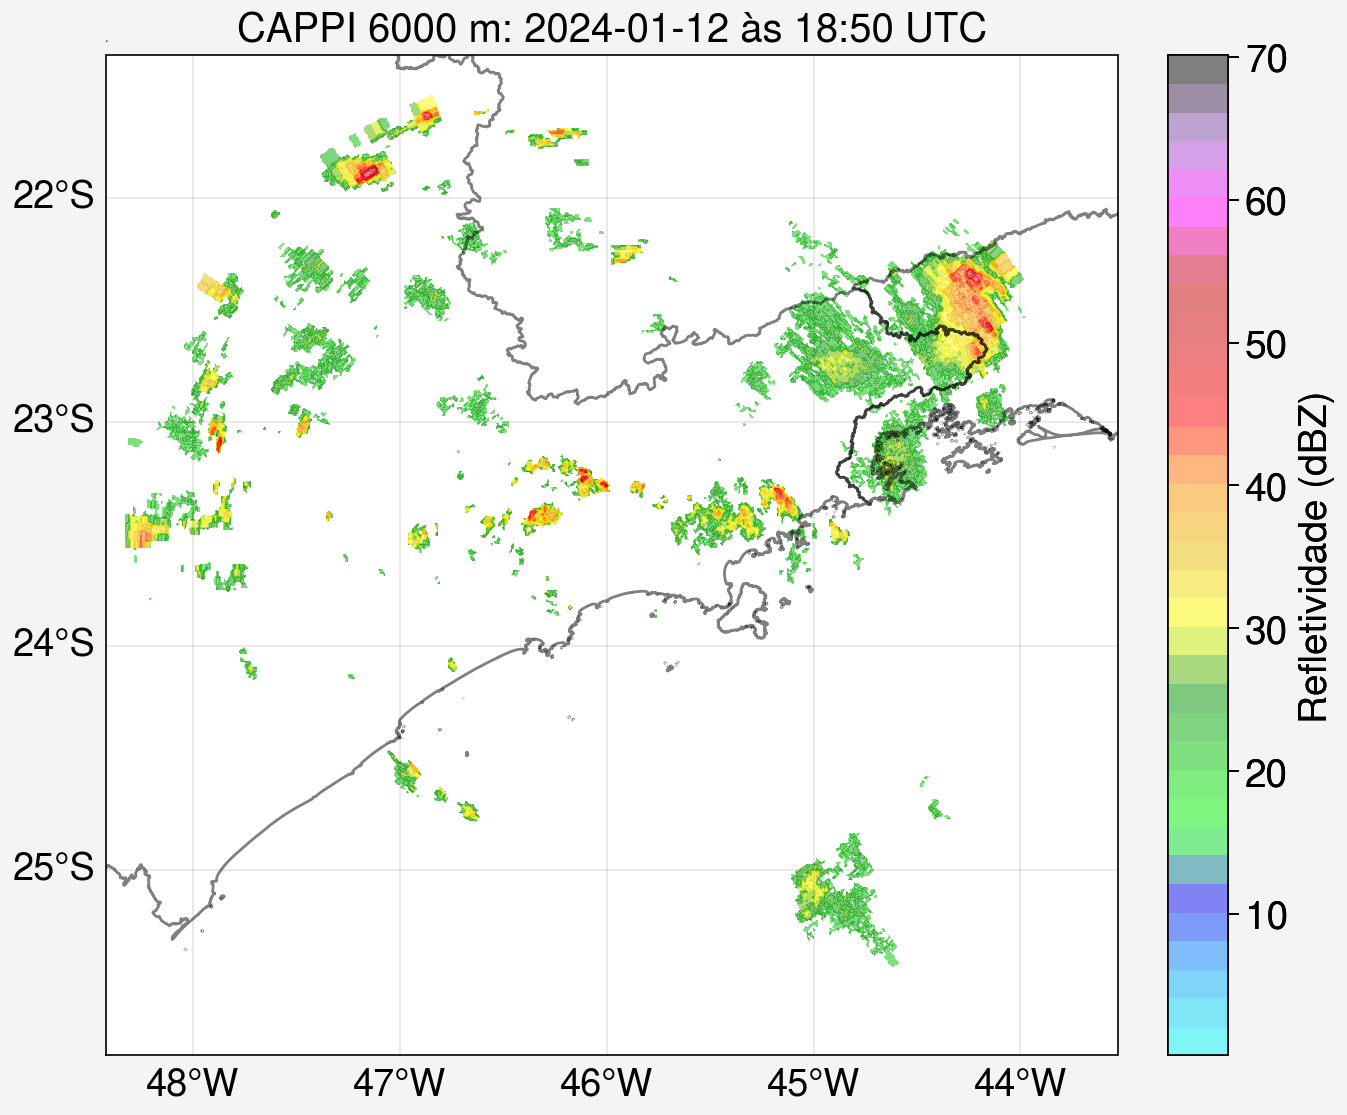

In [25]:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura]) #(=6000)

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos:
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

### Plotando mapa com os valores de refletividade corrigida e filtrada para R >= 20 dBZ:
map1 = ax.contourf(xarray_cappi['lon'], xarray_cappi['lat'],
                   xarray_cappi['corrected_reflectivity'][0, indice_altura, :, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Refletividade (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'Refletividades_Sem_Raios_Grade_Radar_FCTH.png', bbox_inches='tight', dpi=300)

### 6) Plotando estatísticas da refletividade (CAPPI, sem os raios sobrepostos) na grade CONFIGURADA (50 X 50, cada uma de 10 X 10 km):

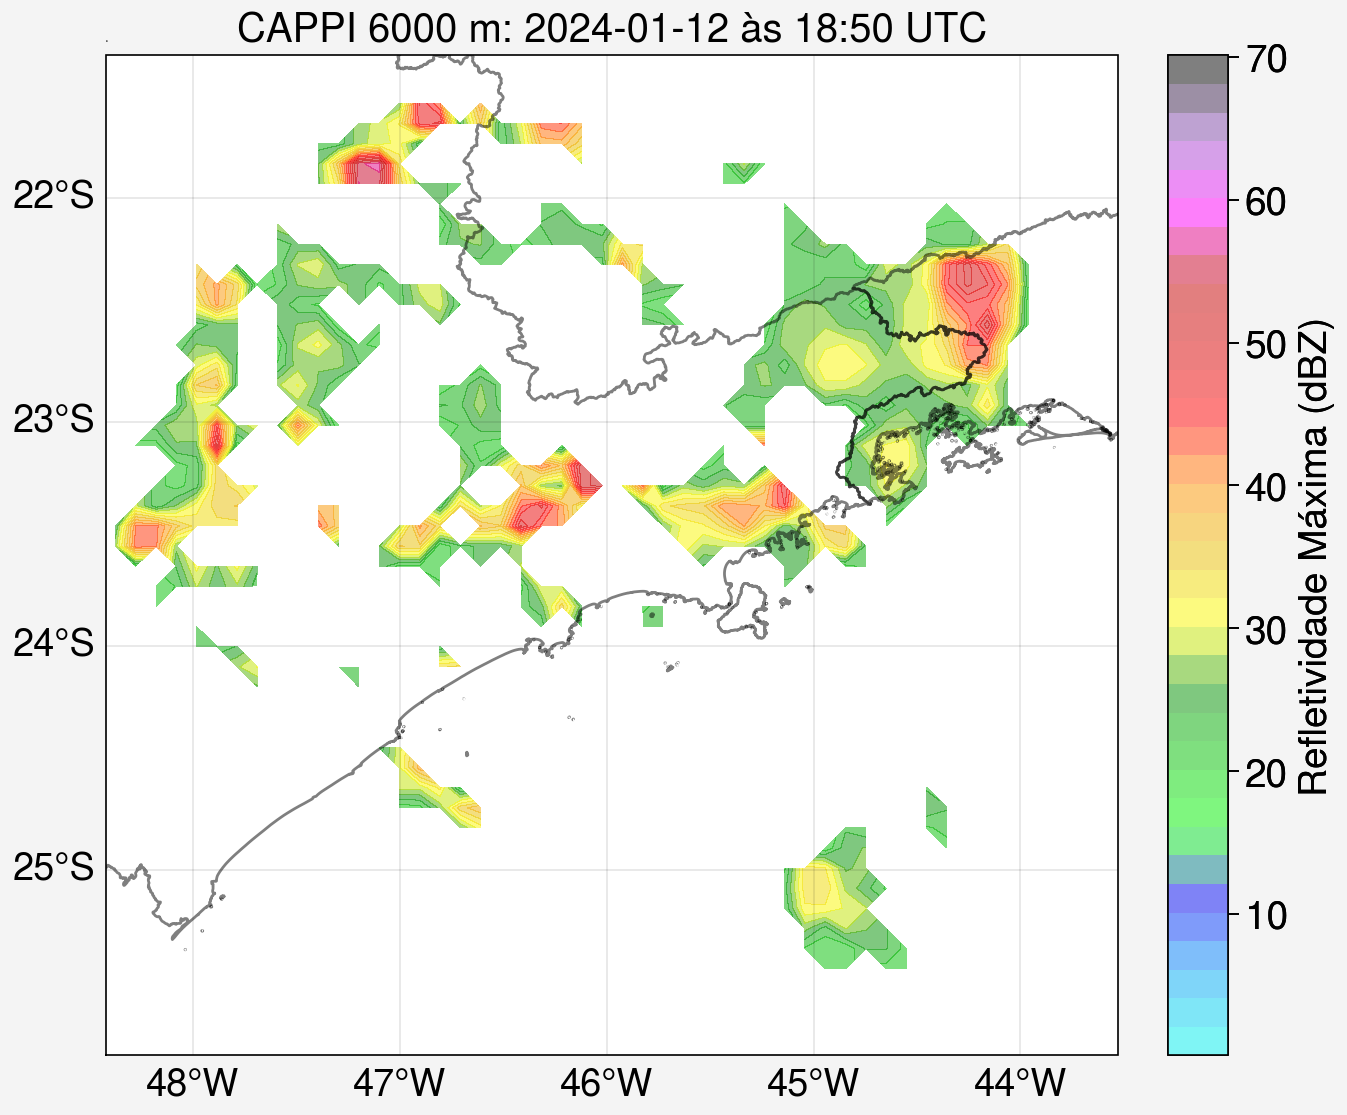

In [26]:
############################################################ Máxima:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada:
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura])

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos:
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

################################ Plotando mapa com os valores de máximos da refletividade, na grade configurada:
xs, ys = np.meshgrid(ds['lat'], ds['lon'])
map1 = ax.contourf(ys, xs,
                   ds['rmax_cappi6'][:, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Refletividade Máxima (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'CAPPI6_RefsMaxs_FCTH.png', bbox_inches='tight', dpi=300)

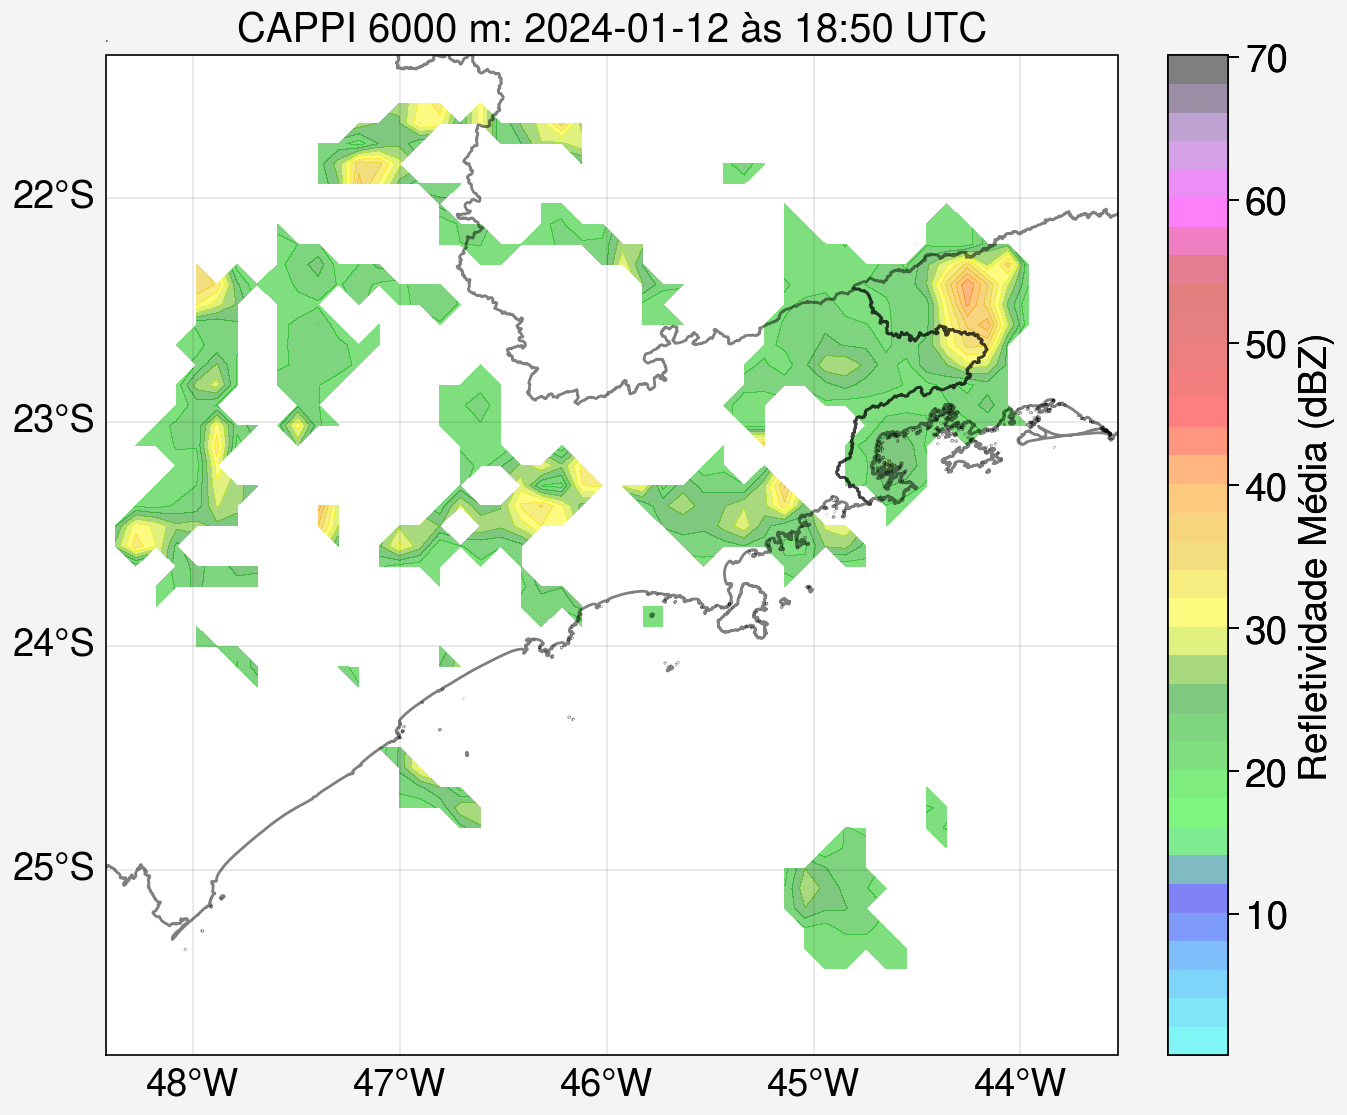

In [27]:
############################################################ Média:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada:
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura])

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos:
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

################################ Plotando mapa com os valores de médias da refletividade, na grade configurada:
xs, ys = np.meshgrid(ds['lat'], ds['lon'])
map1 = ax.contourf(ys, xs,
                   ds['rmedias'][:, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Refletividade Média (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'CAPPI6_RefsMedias_FCTH.png', bbox_inches='tight', dpi=300)

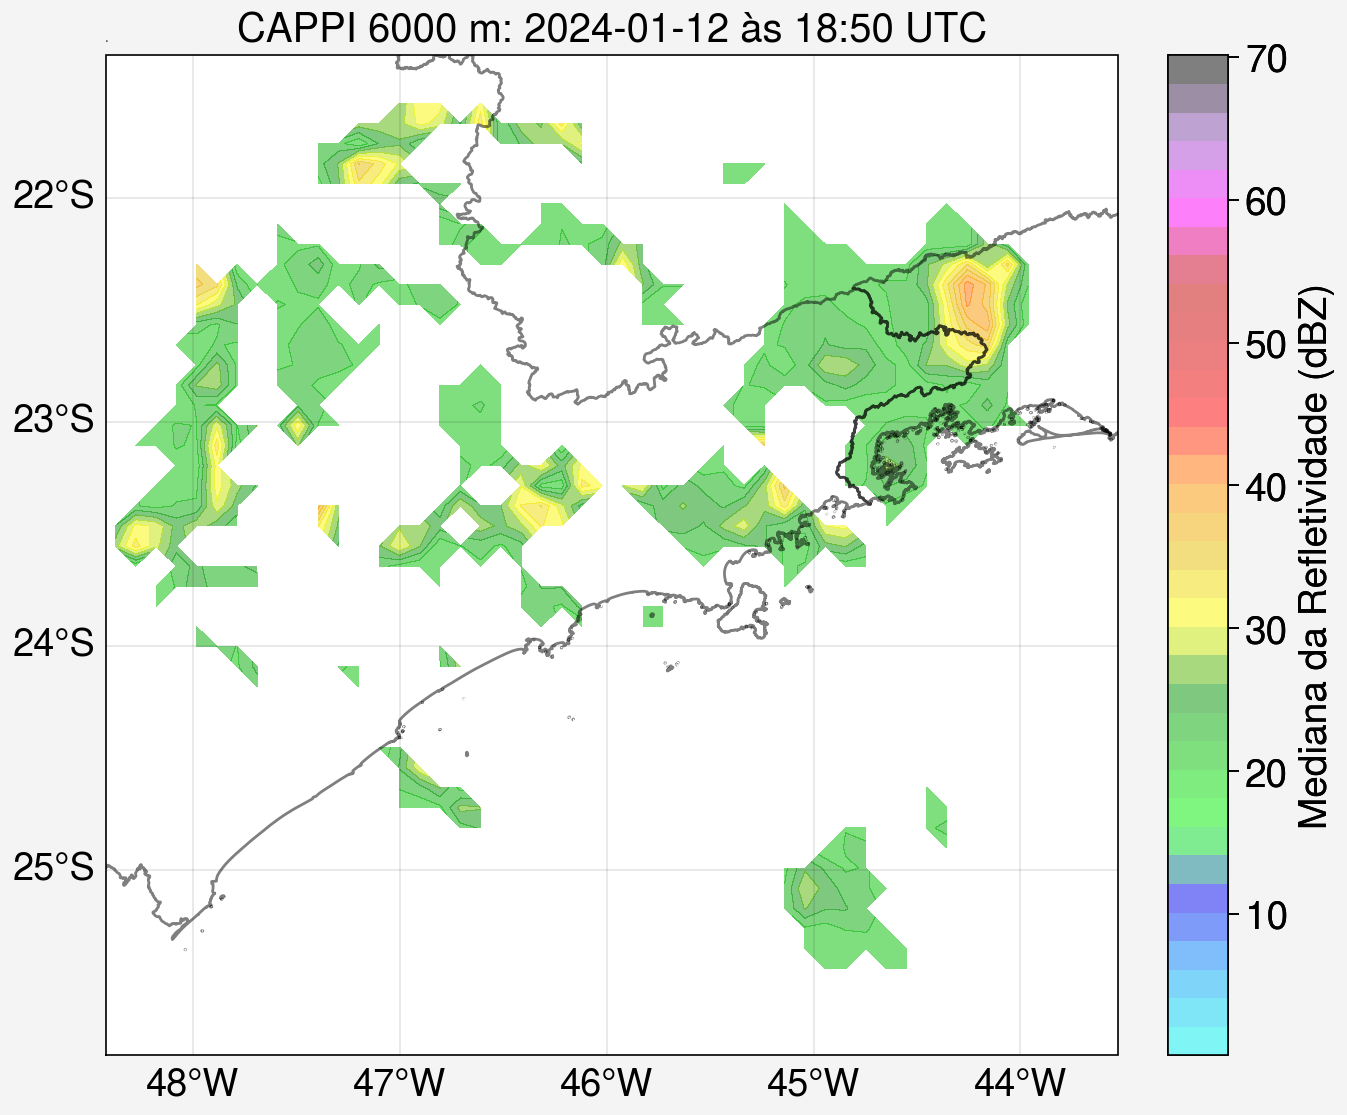

In [28]:
############################################################ Mediana:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada:
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura])

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos:
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

################################ Plotando mapa com os valores de medianas da refletividade, na grade configurada:
xs, ys = np.meshgrid(ds['lat'], ds['lon'])
map1 = ax.contourf(ys, xs,
                   ds['rmedianas'][:, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Mediana da Refletividade (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'CAPPI6_RefsMedianas_FCTH.png', bbox_inches='tight', dpi=300)

### 7) Plotando estatísticas da refletividade SINTÉTICA (CAPPI, sem os raios sobrepostos) na grade CONFIGURADA (50 X 50, cada uma de 10 X 10 km):

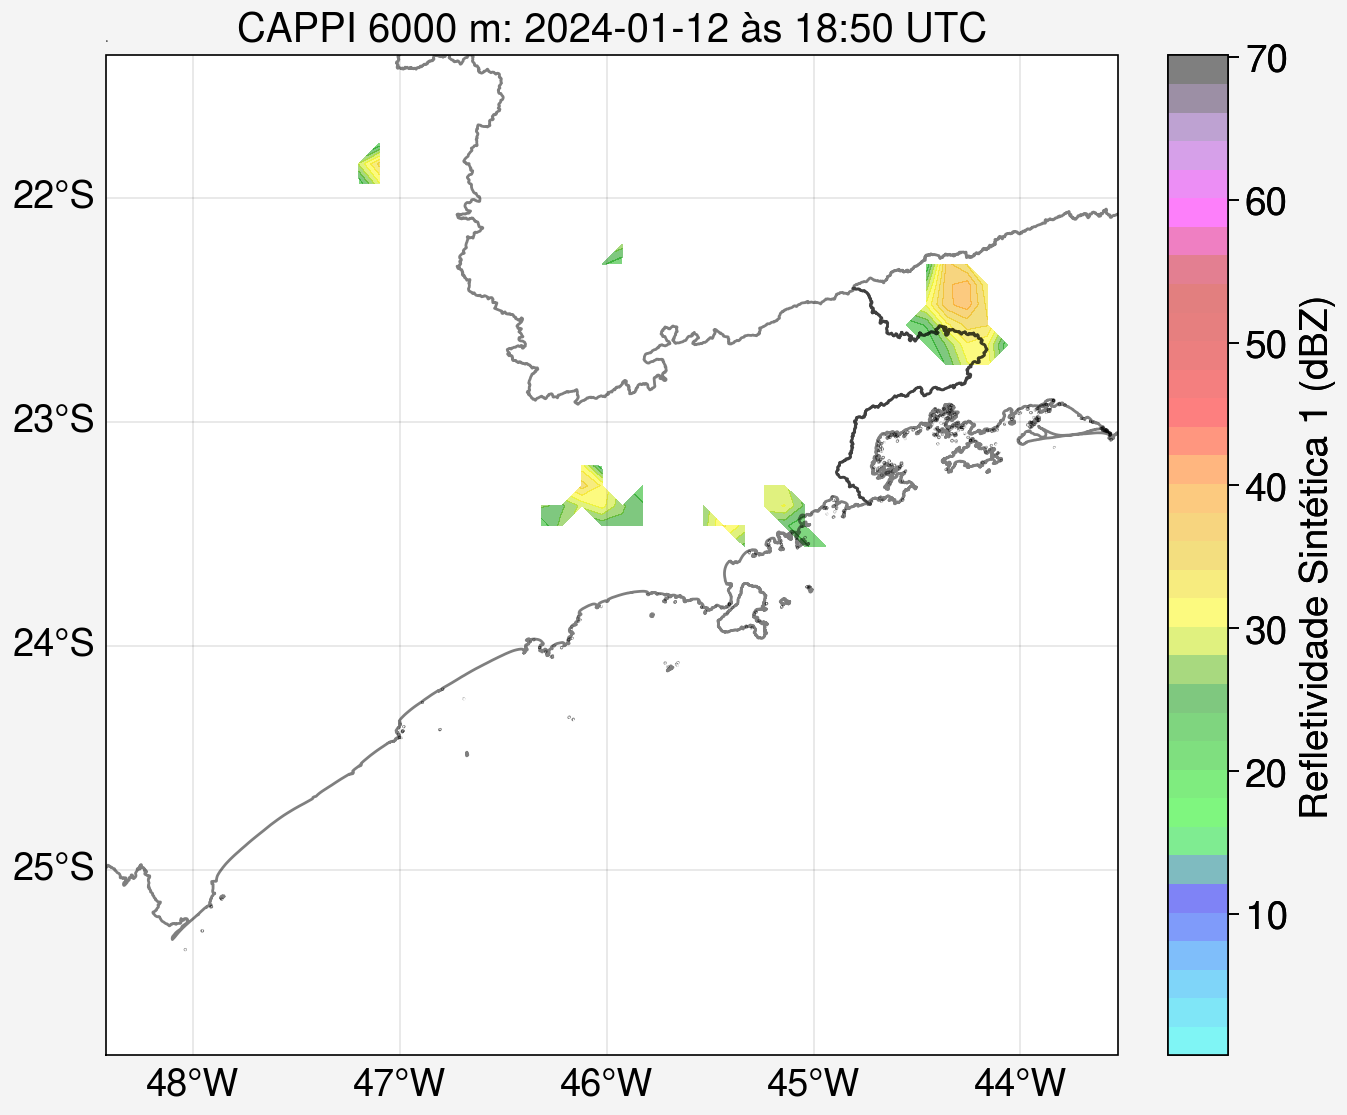

In [29]:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada:
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura])

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

xs, ys = np.meshgrid(ds['lat'], ds['lon'])
map1 = ax.contourf(ys, xs,
                   ds['zsintet1'][:, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Refletividade Sintética 1 (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'CAPPI6_RefsSinteticas1_Medias_FCTH.png', bbox_inches='tight', dpi=300)

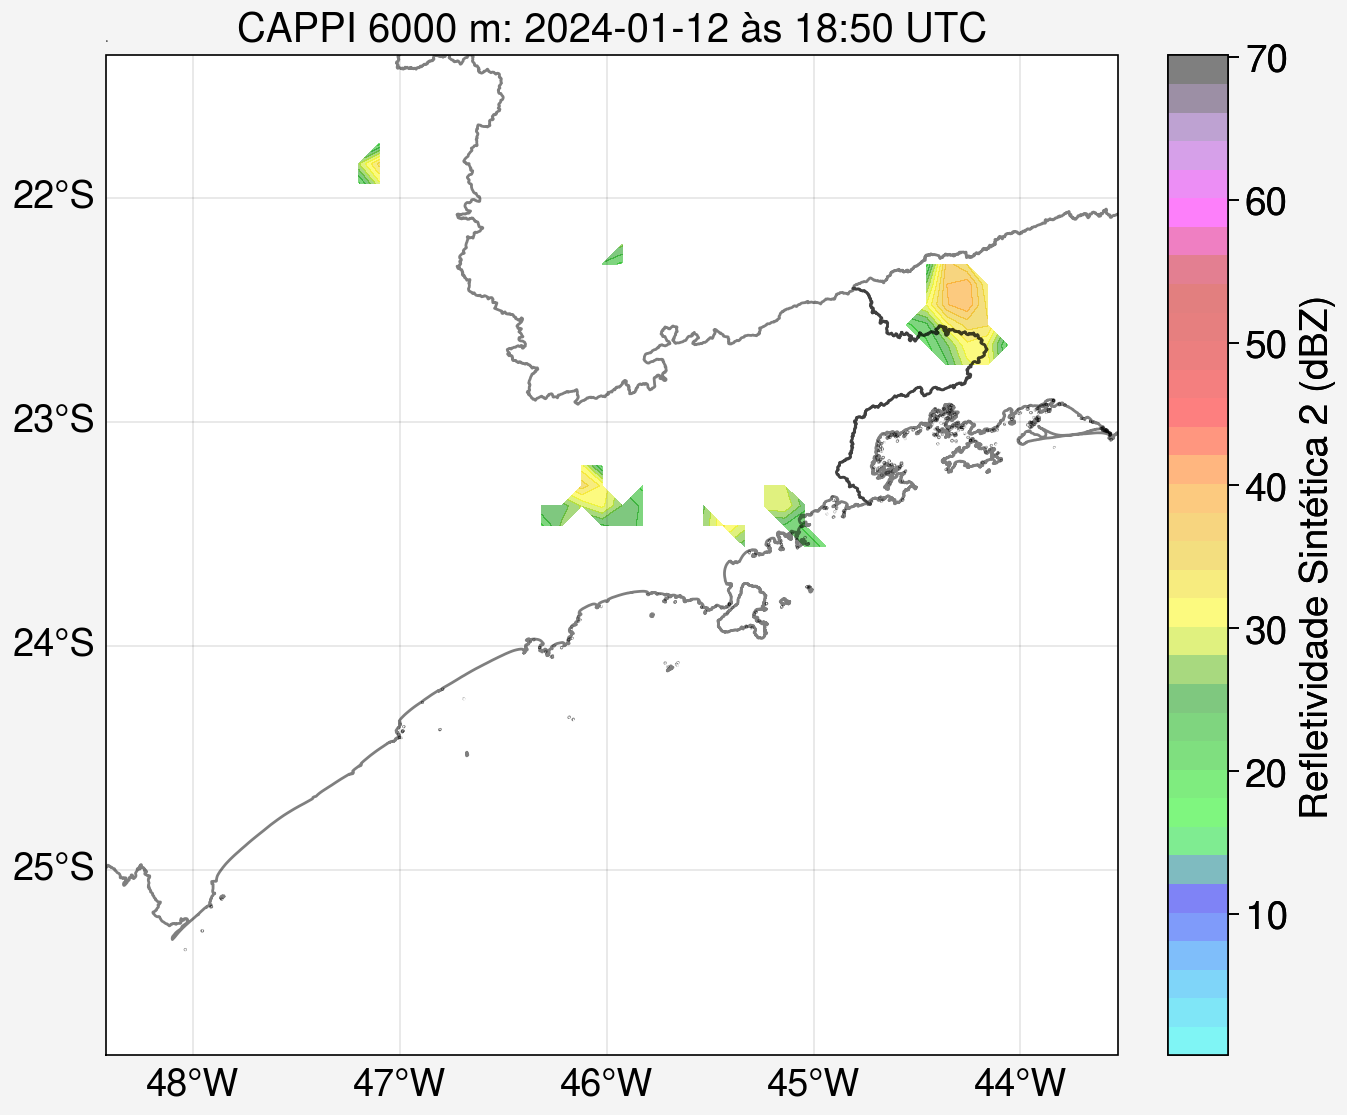

In [30]:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada:
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura])

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos:
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

xs, ys = np.meshgrid(ds['lat'], ds['lon'])
map1 = ax.contourf(ys, xs,
                   ds['zsintet2'][:, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Refletividade Sintética 2 (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'CAPPI6_RefsSinteticas2_Medianas_FCTH.png', bbox_inches='tight', dpi=300)

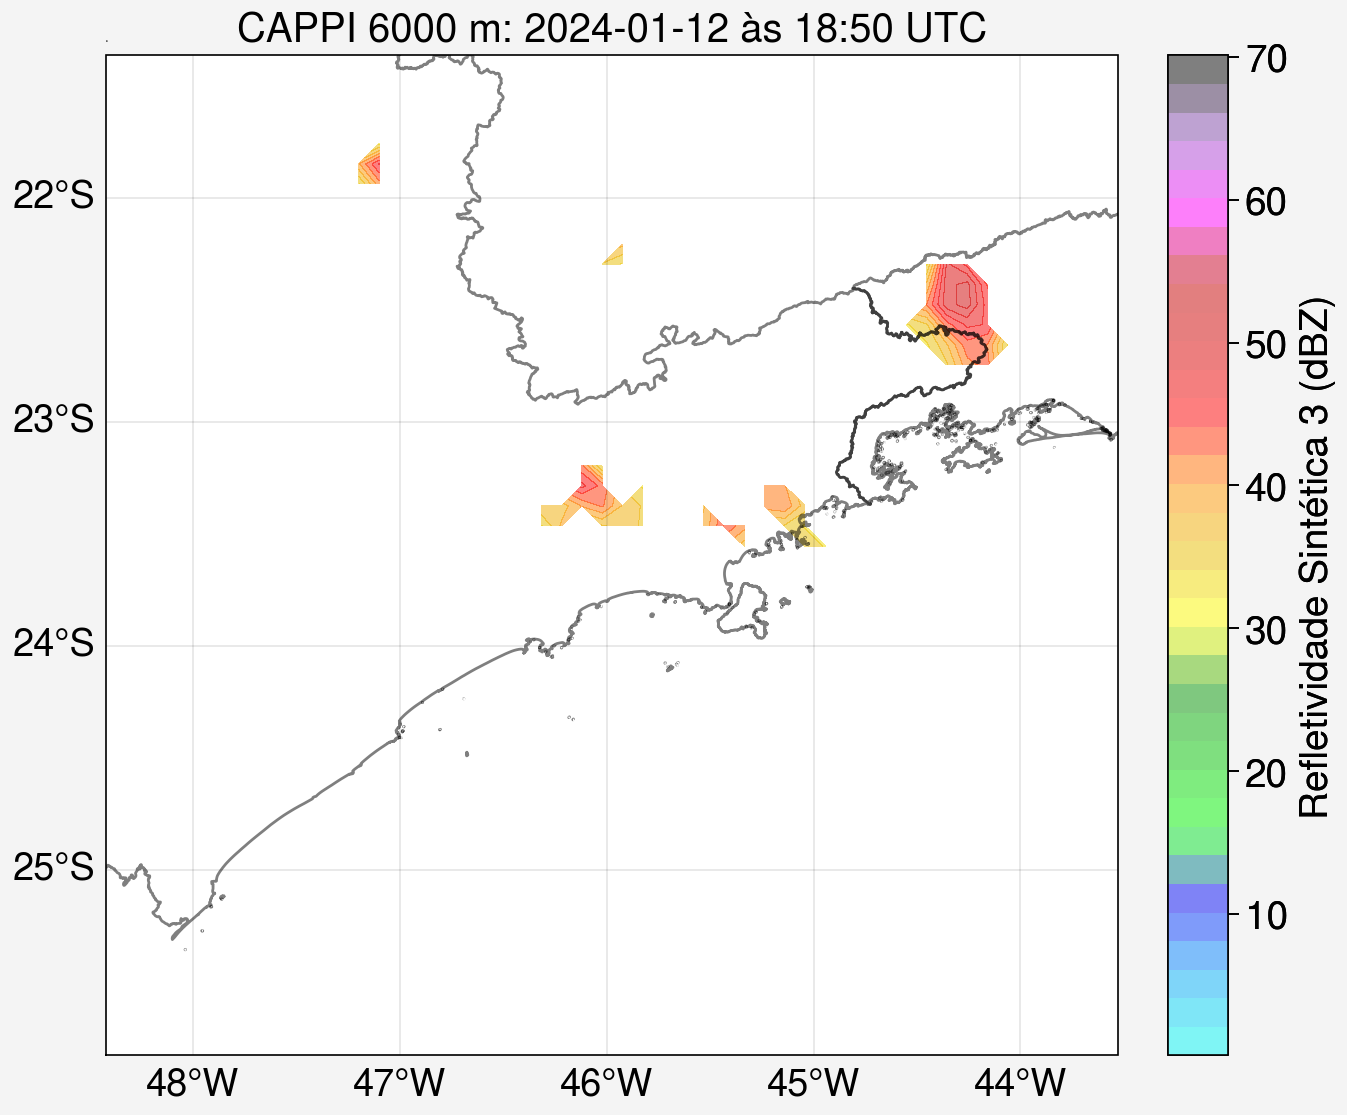

In [31]:
### Definindo qual a "foto" (horário) que será plotada:
xarray_cappi = cappis_filtrados[0]
dic_radar = dics_radares[0]

### Define a altura que será plotada:
indice_altura = 0 #(=6000m)
altura = int(xarray_cappi['z'][indice_altura])

#### Define os limites de dBz na escala:
limdbz = [0, 70]
passo = 2.0

### Cria moldura da figura:
fig, ax = pplt.subplots(axheight=5, tight=True, proj='pcarree')

### Limites da imagem:
lonmin, lonmax = float(xarray_cappi['lon'].min()), float(xarray_cappi['lon'].max())
latmin, latmax = float(xarray_cappi['lat'].min()), float(xarray_cappi['lat'].max())

### Extraindo a data do dado do radar:
data = pyart.util.datetime_from_grid(dic_radar['radar'])
ano = str(data.year)
mes = str(data.month).zfill(2)
dia = str(data.day).zfill(2)
hor = str(data.hour).zfill(2)
minuto = str(data.minute).zfill(2)

### Formatação dos eixos:
ax.format(coast=False, borders=False, innerborders=False, labels=True, latlines=1, lonlines=1,
          title = f'CAPPI {altura} m: {ano}-{mes}-{dia} às {hor}:{minuto} UTC',
          latlim=(latmin-0.07, latmax+0.06),
          lonlim=(lonmin-0.05, lonmax+0.05), small='19px', large='20px', abc=True, abcstyle='a', abcsize=1)

xs, ys = np.meshgrid(ds['lat'], ds['lon'])
map1 = ax.contourf(ys, xs,
                   ds['zsintet3'][:, :],
                   cmap='pyart_NWSRef', alpha=0.5, fontsize = 12,
                   levels=pplt.arange(float(limdbz[0])+0.1, float(limdbz[1]), passo), vmin=limdbz[0], vmax=limdbz[1])

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

### Adicionando paleta de cores e legenda:
fig.colorbar(map1, loc='r', label='Refletividade Sintética 3 (dBZ)', ticks=10, ticklabelsize=14, labelsize=14, width=0.3, space=-1.5)
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':8.5}, markerscale=0.8)

### Salvando a figura:
plt.savefig(output+'CAPPI6_RefsSinteticas3_Maximas_FCTH.png', bbox_inches='tight', dpi=300)